### plot scatterplots of example alpha / threshold combinations

In [11]:
import pandas as pd
import numpy as np
import itertools
import scipy
import tqdm
from scipy.stats import linregress
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

In [12]:
moorings = ['sumata','a','b','d']

In [13]:
thresholds =  np.arange(5,96,2.5)
alphas = np.round(np.arange(0,1.01,0.01),decimals=2)

In [14]:
rho_fyi = 916.7
rho_myi = 882.0

In [15]:
data_name = 'era5'

In [16]:
plt.rc('font', size=15)

In [18]:
moorings = ['sumata','a','b','d']
 
aux_tables = {}

for mooring in moorings:

    aux_file = f'/Users/carmennab/Dropbox/alpha_retracker/data/sit/pysiral/aux_{mooring}.csv'

    aux_tables[mooring] = pd.read_csv(aux_file)
    
aux_tables['a']   

,year,month,mean_era5_sden,mean_era5_snod,mean_era5_snod_90,mean_era5_snod_110,mean_merra2_sden,mean_merra2_snod,mean_ice_density,mean_ice_density_jut,mean_draft,mean_buoy_thickness_era5,mean_buoy_thickness_merra2,mean_buoy_thickness_jut,mean_buoy_thickness_90,mean_buoy_thickness_110
0,2010,10,192.44249,0.027158,0.024442,0.029874,179.00356,0.027081,916.7,928.6171,0.261778,0.286690,0.287103,0.283010,0.287618,0.286557
1,2010,11,266.80045,0.066308,0.059677,0.072939,264.38025,0.066523,916.7,928.6171,0.501364,0.540696,0.540809,0.533757,0.542783,0.538958
2,2010,12,260.80438,0.110834,0.099750,0.121917,263.06238,0.120450,916.7,928.6171,0.734777,0.789170,0.786138,0.779043,0.792078,0.785717
3,2011,1,256.05520,0.099190,0.089271,0.109109,282.02667,0.107682,916.7,928.6171,1.045163,1.139680,1.134257,1.125054,1.139921,1.133818
4,2011,2,249.61423,0.112708,0.101437,0.123979,294.70108,0.122424,916.7,928.6171,1.259129,1.375683,1.367016,1.358029,1.373763,1.366516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,2020,12,298.63495,0.096556,0.086900,0.106211,309.48373,0.137395,916.7,928.6171,0.745481,0.801203,0.786273,0.790921,0.803320,0.796801
73,2021,1,315.00632,0.102995,0.092695,0.113294,343.68842,0.133642,NaN,NaN,1.011286,NaN,NaN,NaN,NaN,NaN
74,2021,2,277.47903,0.183921,0.165529,0.202313,338.95860,0.228458,NaN,NaN,1.307642,NaN,NaN,NaN,NaN,NaN
75,2021,3,292.33566,0.132713,0.119442,0.145985,369.10748,0.173123,NaN,NaN,1.449817,NaN,NaN,NaN,NaN,NaN


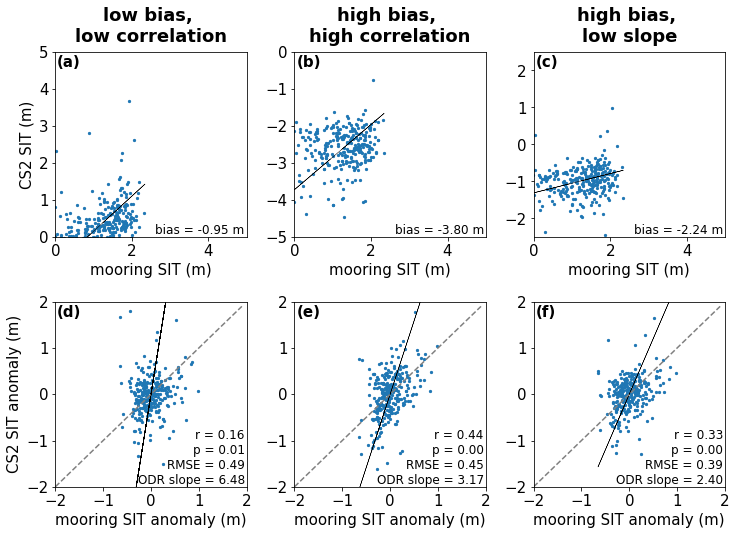

In [41]:
alphas = [0.65,0.65,0.55,0.65,0.65,0.55]
thresholds = [50.0,95.0,70.0,50.0,95.0,70.0]
fig = plt.figure(figsize=(12,8))
spec = gridspec.GridSpec(ncols=3, nrows=2, wspace=0.25, hspace=0.35)

cryo_dir = f'/Users/carmennab/Dropbox/alpha_retracker/data/sit/pysiral/alpha_sits_{data_name}'
all_moorings = ['sumata','a','b','d']
titles = ['low bias, \nlow correlation', 'high bias, \nhigh correlation', 'high bias, \nlow slope']
labels = ['(a)','(b)','(c)','(d)','(e)','(f)']

for count, threshold in enumerate(thresholds):
    
    alpha = alphas[count]

    r_values_dictionary = {} ; bias_dictionary = {} 
    
#     if count < 2:

    values = [] 

    for mooring in all_moorings:

        cryosat_df = pd.read_csv(f'{cryo_dir}/a{alpha}_{mooring}.csv')

        for month, year in zip(cryosat_df['month'],cryosat_df['year']):

            df_cs2_mon_year = cryosat_df[(cryosat_df['month']==month) & (cryosat_df['year']==year)]

            cs2_value = df_cs2_mon_year[f'mean_sit_{threshold}'].iloc[0]
            mooring_value = df_cs2_mon_year['mean_buoy_thickness'].iloc[0]

            values.append({"year":year,"month":month,"cryosat_thickness":cs2_value,
                            "mooring_thickness":mooring_value,"mooring":mooring})

    values_df = pd.DataFrame(values)

    df_anoms = {} ; mooring_anoms = [] ; cryosat_anoms = []
    for mooring in moorings: ### calculate anoms for each mooring 

        mooring_df = values_df[values_df['mooring']==mooring]

        months = set(mooring_df['month'])

        mooring_climatologies = {} ; cryosat_climatologies = {}

        for month in months:
            df_cs2_mon = mooring_df['cryosat_thickness'][mooring_df['month']==month]
            df_mooring_mon = mooring_df['mooring_thickness'][mooring_df['month']==month]

            cryosat_climatologies[month] = np.nanmean(df_cs2_mon)
            mooring_climatologies[month] = np.nanmean(df_mooring_mon)

        monthly_bias = []

        for month, cs2_sit, mooring_sit in zip(mooring_df['month'],mooring_df['cryosat_thickness'],
                                               mooring_df['mooring_thickness']):
            
            if count < 3:
                
                mooring_anoms.append(mooring_sit)
                cryosat_anoms.append(cs2_sit)
                monthly_bias.append(cs2_sit-mooring_sit)
                
            else:
                mooring_anoms.append(mooring_sit-mooring_climatologies[month])
                cryosat_anoms.append(cs2_sit-cryosat_climatologies[month])
                monthly_bias.append(cs2_sit-mooring_sit)

    df_anoms['mooring_anom'] = mooring_anoms ### combine anoms from moorings into one dataframe
    df_anoms['cryosat_anom'] = cryosat_anoms

    c = np.array(df_anoms['cryosat_anom']) ### calculate correlation between moorings and cs2
    m = np.array(df_anoms['mooring_anom'])
    df = pd.DataFrame({'c':c,'m':m}).dropna()

    lr = linregress(df['m'],df['c'])
    pvalue = lr[3]
    pearsonr = lr[2] 
    
    ### calculate slope using ODR
    x = df['m']
    y = df['c']

    def f(B, x):
        return B[0]* x + B[1]

    linear = scipy.odr.Model(f)
    mydata = scipy.odr.Data(x,y)
    myodr = scipy.odr.ODR(mydata,linear,beta0=[1,0])
    output = myodr.run()    
    slope = output.beta[0] 
        
    bias = np.nanmean(monthly_bias)
    
    rmse = np.sqrt(np.nanmean((x-y)**2))

    ### add subplot
    ax = plt.subplot(spec[count])
    ax.scatter(df['m'],df['c'],s=5)
    
    if count < 3:
        ax.set_title(titles[count],fontweight='bold',pad=10)

    if count == 0:
        ax.set_ylabel('CS2 SIT anomaly (m)')

    if count > 2:
        ax.set_xlabel('mooring SIT anomaly (m)')
        ax.text(0.99, 0.015, f"r = {pearsonr:.2f}\np = {pvalue:.2f}\nRMSE = {rmse:.2f}\nODR slope = {slope:.2f}", 
                ha='right',transform = ax.transAxes,fontsize=12)
        
    if count == 0:
        ax.set_ylabel('CS2 SIT (m)')
    if count == 3:
        ax.set_ylabel('CS2 SIT anomaly (m)')

    if count < 3:
        ax.set_xlabel('mooring SIT (m)')
        ax.text(0.99, 0.015, f"bias = {bias:.2f} m", ha='right',transform = ax.transAxes,fontsize=12)
        
    ax.text(0.01, 0.92, labels[count],ha='left',transform = ax.transAxes,fontweight='bold')
    
    line = output.beta[0]* x + output.beta[1]
    ax.plot(df['m'], line,color='k',linewidth=0.5)
    
    if count > 2:
        ax.plot(np.arange(-2,2,0.1), np.arange(-2,2,0.1),linestyle='dashed',color='grey')
    
    if count >2:
        
        ax.set_ylim([-2,2])
        ax.set_xlim([-2,2])
        ax.set_yticks([-2,-1,0,1,2])
        
    if count < 3:
        ax.set_xlim([0,5])

    if count == 0:
        ax.set_ylim([0,5])
    if count == 1:
        ax.set_ylim([-5,0])
    if count == 2:
        ax.set_ylim([-2.5,2.5])
    figpath = f'/Users/carmennab/Dropbox/Apps/Overleaf/Alpha Retracker/supp_figs/scatterplots.jpg'
    plt.savefig(figpath,bbox_inches = "tight",dpi = 400)